[En français](../use-case-oafeat-en/)  

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TOC](https://eccc-msc.github.io/open-data/readme_en/) > [Usage overview](https://eccc-msc.github.io/open-data/usage/readme_en/) > OGC API - Features request in Python

# Use case: Tracking water level with GeoMet-OGC-API

## Introduction

Hydrometric data from the Meteorological Service of Canada (MSC) and Environment and Climate Change Canada (ECCC) can be easily accessed via [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html). The [OGC API - Features](https://eccc-msc.github.io/open-data/msc-geomet/web-services_en/#ogc-api-features) web services available in [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html) offer the capability to query vector geospatial data and retrieve it in a GeoJSON format. The GeoJSON file can than be used for display or further data processing. This use case will show you how you can:
* Query and retrieve vector geospatial data from [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html) with [Python](https://www.python.org/)
* Display the retrieved data on a web map
* Analyse the data and display the results in graphic and tabular format
* Export the data in a format of your choice

An [interactive version of this Jupyter Notebook is available](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case-oafeat-en.ipynb)

[![badge](https://img.shields.io/badge/Interactive%20version-binder-F5A252.svg?logo=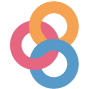)](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case-oafeat-en.ipynb)

## Creation of a tool to track water level 

Cathy runs a boat tours and water sports company in Chilliwack, British-Columbia. She would like to track the water level of a few hydrometric stations near her city to guide the management of the company activities. She would like to have:
* An overview of the distribution of the daily water level of the past 3 months for all hydrometric stations located within 100 km of the city of Chilliwack (minimum, first quartile, median, third quartile and maximum) 
* A graphic view that presents the provisional daily mean water level of the past 3 months with a color code to indicate the water level status
* A tabular view that shows the provisional daily mean water level of the past 3 months with the same color code
* A web map that displays the hydrometric stations located within 100 km of the city of Chilliwack and the most recent provisional daily mean water level of these stations with the appropriate color code

To achieve this, the first step is to import the necessary Python modules and to select the desired request parameters.

In [1]:
# Modules importation
from datetime import date

from dateutil.relativedelta import relativedelta
from ipyleaflet import (
    AwesomeIcon,
    basemaps,
    FullScreenControl,
    LegendControl,
    Map,
    Marker,
    ScaleControl,
    WidgetControl,
)
from ipywidgets import HTML, interactive, interact
from osgeo import ogr, osr
from owslib.ogcapi.features import Features
import pandas as pd

In [2]:
# Parameters

# Coordinates
lat = 49.162676
long = -121.958943

# Buffer size in kilometer
buffer = 100

# Number of months used to analyse historical data
num_months = 3

# Prefered projection
# NAD83 / Statistics Canada Lambert
projection = 3347

In [3]:
# Parameters formatting for the OGC API - Features request

# Bounding box a little bigger than buffer size (1 km ≈ 0.01°)
bbox = [
    str(long - buffer * 0.01),
    str(lat - buffer * 0.01),
    str(long + buffer * 0.01),
    str(lat + buffer * 0.01),
]

# Time
end_date = date.today()
end_date = date(2012, 7, 20)  # Available data to test the code
start_date = end_date - relativedelta(months=num_months)
delta_time = (end_date - start_date).days
time = f'{start_date.strftime("%Y-%m-%d")}/{end_date}'

Than, the [hydrometric monitoring stations data](https://geo.weather.gc.ca/geomet/features/collections/hydrometric-stations) available on GeoMet-OGC-API can be retrieved with the [OWSLib package](https://geopython.github.io/OWSLib/). As the bounding box parameter is not as precise as a round buffer, [GDAL](https://gdal.org/api/index.html#python-api) can be used to select only the hydrometric stations that are strictly inside a 100 km radius from Chilliwack.

In [4]:
# Retrieval of hydrometric stations data
oafeat = Features("https://geo.weather.gc.ca/geomet/features")
station_data = oafeat.collection_items(
    "hydrometric-stations", 
    bbox=bbox, 
    STATUS_EN="Active"
)

In [5]:
# List of stations located inside the buffer zone

# Data formatting to be compatible with the GeoJSON driver 
station_data = str(station_data).replace("'", '"').replace("None", "null")

# Accessing the hydrometric station layer
driver = ogr.GetDriverByName("GeoJSON")
data_source = driver.Open(station_data, 0)
layer = data_source.GetLayer()

# Identification of the input spatial reference system
srs_input = layer.GetSpatialRef()
sr = osr.SpatialReference(str(srs_input))
epsg = sr.GetAuthorityCode(None)
srs_input.ImportFromEPSG(int(epsg))

# Definition of the spatial reference system used to project data
srs_projected = osr.SpatialReference()
srs_projected.ImportFromEPSG(projection)

# Transformation from input srs to the prefered projection
transform = osr.CoordinateTransformation(srs_input, srs_projected)

# Creation of a buffer to select stations
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(long, lat)
point.Transform(transform)
point_buffer = point.Buffer(buffer * 1000)  # The value must be in meters

# Selection of the stations in the buffer zone
stations = []
for feature in layer:
    geom = feature.GetGeometryRef().Clone()
    geom.Transform(transform)
    if geom.Intersects(point_buffer):
        stations.append(feature.GetField("STATION_NUMBER"))

Once the hydrometric monitoring stations located within 100 km of Chilliwack are identified, the water level data of the past three months can be retrieved for each station. The provisional daily mean water level will than be calculated for each day of the 3 months period. A water level status will be attributed to each daily mean according to which quartile of the historical  daily water level of the past 3 months the value is part of.

|Quartile|Water level status|Color|
|---|---|---|
|Upper quartile|High|Red|
|Between the upper quartile<br>and the lower quartile|Medium|Blue|
|Lower quartile|Low|Green|

The provisional daily mean water level of the past 3 months will be used to create a data frame of the historical daily water level for each station with [Pandas](https://pandas.pydata.org/). To facilitate the data manipulations, all the data frames will be gathered in a Python dictionary. These data frames will be used to create an interactive graphic and tabular view of the historical daily water level of the hydrometric monitoring stations located within 100 km of Chilliwack. The most recent provisional daily mean water level of all the stations will also be compiled in a single data frame that will be used to display the most recent water level data on an interactive map.

To prevent any issues related to data unavailability for a station in the designated time period, any station for which a daily mean can not be calculated for a day within the past 3 months will be removed from the data.

In [6]:
# Retrieval of hydrometric data for each station

# Function to associate a status to each water level
def level_status(level_value, df):
    if level_value < df.quantile(0.25)[0]:
        status = "Low"
    elif level_value > df.quantile(0.75)[0]:
        status = "High"
    else:
        status = "Medium"
    return status


# Dictionary that will contain a data frame for each station with the
# historical daily water level for the time period
water_level = {}

# Dictionary that will be used to create a data frame with the latest
# data of all stations
latest_data = {
    "ID": [],
    "Name": [],
    "Level": [],
    "Timestamp": [],
    "Status": [],
    "Latitude": [],
    "Longitude": [],
}

# List of stations with missing data
to_remove = []

# Data retrieval and creation of the data frames
for station in stations:

    # Retrieval of water level data
    hydro_data = oafeat.collection_items(
        "hydrometric-daily-mean", bbox=bbox, time=time, STATION_NUMBER=station
    )

    # Creation of a dataframe if there is data for the whole time period
    if (
        len(hydro_data["features"]) == delta_time + 1
        and hydro_data["features"][-1]["properties"]["LEVEL"] is not None
    ):
        # Extraction of dates and water level for the whole time period
        dates = []
        level_values = {"Daily mean": []}
        for feature in hydro_data["features"]:
            dates.append(feature["properties"]["DATE"])
            level_values["Daily mean"].append(feature["properties"]["LEVEL"])
        
        # Creation of a dataframe with the historical daily water level data
        water_level_df = pd.DataFrame(
            level_values, index=dates, columns=["Daily mean"]
        )
        water_level_df["Status"] = water_level_df["Daily mean"].apply(
            level_status, df=water_level_df
        )
        
        # Adding the historical daily water level data frame to the dictionary
        water_level[station] = water_level_df
        
        # Adding the latest water level data to the second dictionary
        last_value = hydro_data["features"][-1]["properties"]
        last_coord = hydro_data["features"][-1]["geometry"]["coordinates"]
        latest_data["ID"].append(station)
        latest_data["Name"].append(last_value["STATION_NAME"])
        latest_data["Level"].append(round(last_value["LEVEL"], 2))
        latest_data["Timestamp"].append(last_value["DATE"])
        latest_data["Status"].append(water_level_df["Status"][-1])
        latest_data["Latitude"].append(last_coord[1])
        latest_data["Longitude"].append(last_coord[0])

    else:
        to_remove.append(station)

# Removing hydrometric stations with insufficient data from the station list
for station in to_remove:
    stations.remove(station)

# Transformtion of the latest water level data dictionary into a dataframe
latest_data_df = pd.DataFrame.from_dict(latest_data)

Now that all the data frames are ready, the data can be visualized in a graphic view. Pandas can be used to generate interactive plots on Jupyter Notebook with the [Plotly backend](https://plotly.com/python/pandas-backend/). A dropdown menu can be added in Jupyter Notebook with ipywidget to select the desired hydrometric monitoring station.

In [7]:
# Creation of an interactive plot with pandas and plotly
pd.options.plotting.backend = "plotly"


# Function to show the plot of the chosen hydrometric station
def choose_station(station):
    # Latest data
    curr_value = water_level[station]["Daily mean"].iloc[-1]
    curr_status = water_level[station]["Status"].iloc[-1]
    curr_date = water_level[station].index.max()

    # Historical data
    historical_min = float(water_level[station]["Daily mean"].min())
    historical_max = float(water_level[station]["Daily mean"].max())

    # Number of level values
    num_values = len(water_level[station].index)

    # Current level line color that to indicate the water level status
    if curr_status == "Low":
        curr_color = "limegreen"
    elif curr_status == "High":
        curr_color = "red"
    else:
        curr_color = "cornflowerblue"

    # Creation of the plot
    fig = (
        water_level[station]["Daily mean"]
        .plot(
            title="Water level at station {}".format(station),
            template="plotly_white",
            labels=dict(index="Date", value="Water level (m)"),
            color_discrete_sequence=["gray"],
        )
        .add_scatter(  # Historical maximum line
            y=[historical_max] * num_values,
            x=water_level[station].index,
            name="Historical maximum",
            line=dict(color="red", dash="dash"),
            text=f"Historical maximum: {round(historical_max, 3)}",
            hoverinfo="x+text",
            legendgroup="General legend",
        )
        .add_scatter(  # Historical minimum line
            y=[historical_min] * num_values,
            x=water_level[station].index,
            name="Historical minimum",
            line=dict(color="limegreen", dash="dash"),
            text=f"Historical minimum: {round(historical_min, 3)}",
            hoverinfo="x+text",
            legendgroup="General legend",
        )
        .add_scatter(  # Current level legend header
            y=[curr_value],
            x=[curr_date],
            name="Current level",
            legendgroup="Current value legend",
            opacity=0,
        )
        .add_scatter(  # High level legend key
            y=[curr_value],
            x=[curr_date],
            name="High",
            line=dict(color="red"),
            legendgroup="Current value legend",
        )
        .add_scatter(  # Medium level legend key
            y=[curr_value],
            x=[curr_date],
            name="Medium",
            line=dict(color="cornflowerblue"),
            legendgroup="Current value legend",
        )
        .add_scatter(  # Low level legend legend key
            y=[curr_value],
            x=[curr_date],
            name="Low",
            line=dict(color="limegreen"),
            legendgroup="Current value legend",
        )
        .add_scatter(  # Current level line
            y=[curr_value] * num_values,
            x=water_level[station].index,
            name="Current level",
            line=dict(color=curr_color),
            showlegend=False,
        )
    )
    # Updating plot parameters
    fig.update_traces(
        legendgroup="General legend",
        selector=dict(name="Daily mean")
    )
    fig.update_traces(hovertemplate=None, mode="lines")
    fig.update_layout(
        hovermode="x unified",
        legend_title=None,
        legend_tracegroupgap=25,
        yaxis=dict(range=[historical_min - 0.1, historical_max + 0.1]),
    )
    # Traces added to create the custom legend shouldn't be included
    # in the information shown when hovering over the plot
    fig.update_traces(
        hoverinfo="skip", selector=dict(egendgroup="Current value legend")
    )
    return fig


# Creation of the dropdown menu widget
graph = interact(choose_station, station=stations)

interactive(children=(Dropdown(description='station', options=('08MF005', '08MF035', '08MF062', '08MF065', '08…

A similar dropdown widget can be used to select which hydrometric monitoring station data to show in the interactive data table.

In [8]:
# Creation of the table

# Option to show all rows
pd.set_option("max_rows", None)


# Function to change cell color according to
# current water level status
def cell_color(row, status):
    cell = row.index.get_loc("Daily mean")
    color = ["" for _ in row.index]
    if status.loc[row.name] == "Low":
        color[cell] = "background-color: limegreen"
    elif status.loc[row.name] == "High":
        color[cell] = "background-color: red"
    else:
        color[cell] = "background-color: cornflowerblue"
    return color


# Function to show the table of the chosen hydrometric station
# with the appropriate cell color
def choose_station_table(station):
    df = water_level[station][["Daily mean"]]
    return df.style.apply(
        cell_color,
        axis=1,
        status=water_level[station]["Status"]
    )


# Creation of the dropdown menu widget
table = interact(choose_station_table, station=stations)

interactive(children=(Dropdown(description='station', options=('08MF005', '08MF035', '08MF062', '08MF065', '08…

Finally, an interactive map can be created with ipyleaflet to display the most recent water level daily mean of all the hydrometric monitoring stations located within 100 km of Chilliwack.

In [9]:
# Creation of the interactive map

# Parameters
center = [lat, long]
zoom = 8

# Map
m = Map(basemap=basemaps.CartoDB.Positron, center=center, zoom=zoom)

# Adding hover information
html = HTML("Hover Over Hydrometric Stations")
html.layout.margin = "0px 10px 10px 10px"
control = WidgetControl(widget=html, position="topright", max_width=250)
m.add_control(control)


def get_callback(marker):
    def callback(*args, **kwargs):
        html.value = """
            <b>{}</b><br>
            Station ID: {}<br>
            Date: {}<br>
            Water level: {} m
        """.format(
            marker.Name, marker.ID, marker.Timestamp, marker.Level
        )

    return callback


# Adding legend
legend = LegendControl(
    {"High": "#c64b36", "Medium": "#09639b", "Low": "#6da824"},
    position="bottomright",
    name="Water level",
)
m.add_control(legend)

# Adding scale and full screen control
m.add_control(ScaleControl(position="bottomleft"))
m.add_control(FullScreenControl())

# Marker colors according to current water level status
marker_color = {"Low": "green", "Medium": "darkblue", "High": "red"}

# Adding a marker to the map for each hydrometic station
for index, row in latest_data_df.iterrows():
    icon = AwesomeIcon(name="tint", marker_color=marker_color[row.Status])
    station_marker = Marker(
        icon=icon, 
        location=[row.Latitude, row.Longitude],
        draggable=False
    )
    station_marker.on_mouseover(get_callback(row))
    m.add_layer(station_marker)

# Display the map
display(m)

Map(center=[49.162676, -121.958943], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…